#Baseline estimator implementation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def gradient_J(R, B_i, B_u, mu, lambda_1=0.02):
    """Calculate stochastic gradient descent for the Baseline model.

    Parameters:
        R (coo_matrix): Rating matrix.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        lambda_1 (float): Penality coefficient.

    Returns:
        b_i (1-D np.array): Gradient of observed deviation for each movie.
        b_u (1-D np.array): Gradient of observed deviation for each user.

    """
    users, items = R.nonzero()
    b_u, b_i =  np.zeros(len(B_u)), np.zeros(len(B_i))
    for u, i in zip(users, items):
        e = R[u, i] - (B_i[i] + B_u[u] + mu)
        b_u[u] += e - lambda_1*B_u[u]
        b_i[i] += e - lambda_1*B_i[i]

    return -2*b_i, -2*b_u

In [0]:
def rmse(R, B_i, B_u, mu):
    """Calculate the root-mean-square deviation using the
       estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.

    Returns:
        error (float): RMSE error value.

    """

    users, items = R.nonzero()
    error = 0
    for u, i in zip(users, items):
        error += pow(R[u, i] - mu - B_u[u] - B_i[i], 2)
    error = (1 / R.shape[0]) * error

    return error

In [0]:
def recreate_matrix(B_i, B_u, mu):
    """Recreate the matrix using estimated parameters.

    Parameters:
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.

    Returns:
        R_estimated (2-D np.array): Recreated rating matrix.

    """

    R_estimated = mu  + B_i[np.newaxis:,] + B_u[:,np.newaxis]

    return R_estimated

In [0]:
def baseline_estimator(R, N, delta=0.01, lambda_1=0.02, verbose=False, plot=False):
    """Estimate Baseline model parameters using SGD.

    Parameters:
        R (coo_matrix): Rating matrix.
        N (int): Number of iterations.
        delta (float): Learning rate.
        lambda_1 (float): Penality coefficient.
        plot (boolean): Plot RMSE track if True.
        verbose (boolean): Print number of the current iteration at excecution.

    Returns:
        B_i_opt (1-D array): Optimal observed deviation for each movie.
        B_u_opt (1-D array): Optimal observed deviation for each user.

    """

    # Weight initialization
    B_u = 2.5 * np.random.rand(R.shape[0])
    B_i = 2.5 * np.random.rand(R.shape[1])

    # Logs initialization
    mse_track = np.zeros(N) 
    w_track = []

    # Calculate overall average rating value
    mu = R.data.mean()

    # Convert R into a csr_matrix
    R = R.tocsr()

    # SDG on N iterations
    for i in range(N):
        if verbose : 
            print("Iteration "+ str(i))
        
        # Calculate SGD 
        gradient = gradient_J(R, B_i, B_u, mu, lambda_1)
        B_i = B_i - delta * gradient[0] 
        B_u = B_u - delta * gradient[1]

        # Saving RMSE values
        mse_track[i] = rmse(R, B_i, B_u, mu)

        # Saving estimated parameters
        w_track.append([B_i, B_u])

    # Selecting the optimal parameters
    idx_min = np.argmin(mse_track)
    B_i_opt = w_track[idx_min][0]
    B_u_opt = w_track[idx_min][1]

    # PLoting RMSE deviation if plot is True
    if plot:
        mse_track = np.array([float(round(mse,3)) for mse in mse_track])
        plt.figure(figsize = (20,8))
        plt.rcParams['axes.facecolor'] = 'orange'
        plt.grid(c='white')
        plt.plot(np.arange(0,N), mse_track, 'blue')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Minimum MSE = {:.4f} reached at iteration {}'.format(min(mse_track),idx_min+1), fontsize = 15)
        plt.axvline(x = idx_min, color = 'green')

    return B_i_opt, B_u_opt

# Dump example

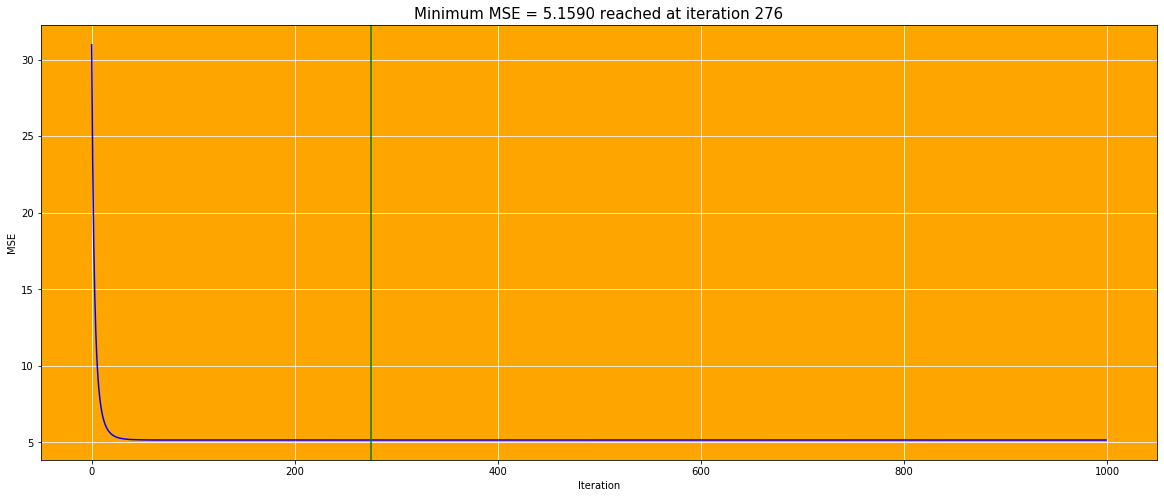

In [0]:
from scipy.sparse import coo_matrix
R = coo_matrix(np.array([
                [0, 3, 0, 4, 0, 5, 2],
                [1, 0, 0, 2, 1, 2, 0],
                [5, 2, 4, 5, 0, 0, 3],
                [3, 0, 0, 3, 5, 5, 1],
                [1, 0, 5, 0, 1, 1, 0],
                [2, 4, 1, 4, 2, 3, 0],
                [0, 0, 0, 2, 0, 0, 4],
                [1, 4, 4, 3, 3, 0, 2]]
))

B_i_opt, B_u_opt = baseline_estimator(R, N=1000, delta=0.01, lambda_1=0.02, verbose=False, plot=True)

In [0]:
R_estimate = recreate_matrix(B_i_opt, B_u_opt, mu=R.data.mean())
R_estimate

array([[3.00491409, 3.55578326, 4.21393419, 3.76919192, 3.46894889,
        4.13860179, 2.48698481],
       [0.93846301, 1.48933218, 2.14748311, 1.70274084, 1.4024978 ,
        2.07215071, 0.42053373],
       [3.3784423 , 3.92931147, 4.5874624 , 4.14272013, 3.84247709,
        4.51213   , 2.86051302],
       [3.01808035, 3.56894952, 4.22710045, 3.78235818, 3.48211514,
        4.15176805, 2.50015107],
       [1.31965773, 1.8705269 , 2.52867784, 2.08393557, 1.78369253,
        2.45334543, 0.80172845],
       [1.98688811, 2.53775728, 3.19590822, 2.75116595, 2.45092291,
        3.12057581, 1.46895883],
       [2.86962179, 3.42049096, 4.07864189, 3.63389962, 3.33365658,
        4.00330949, 2.35169251],
       [2.42015956, 2.97102873, 3.62917966, 3.18443739, 2.88419435,
        3.55384726, 1.90223028]])

In [0]:
R.toarray()

array([[0, 3, 0, 4, 0, 5, 2],
       [1, 0, 0, 2, 1, 2, 0],
       [5, 2, 4, 5, 0, 0, 3],
       [3, 0, 0, 3, 5, 5, 1],
       [1, 0, 5, 0, 1, 1, 0],
       [2, 4, 1, 4, 2, 3, 0],
       [0, 0, 0, 2, 0, 0, 4],
       [1, 4, 4, 3, 3, 0, 2]])

# Real application

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***L'execution de cette partie prend beaucoup de temps sur Colab !***

In [0]:
from scipy.sparse import save_npz, load_npz, coo_matrix

def load_matrix(M_name):
    """ Load previously saved sparce matrix M.

    Parameters:
        M_name (string): Matrix name as saved in drive (R, T or D).

    Returns:
        M (coo_matrix): Saved matrix.

    """

    M = load_npz("/content/drive/My Drive/Factorisation matricielle - dataset/training_set_csv/"+M_name+".npz")

    return M

In [0]:
# Loading R matrix

R = load_matrix("R")

In [0]:
import datetime
start = datetime.datetime.now()

B_i_opt, B_u_opt = baseline_estimator(T, N=500, delta=0.01, lambda_1=0.02, verbose=False, plot=True)

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))

In [0]:
import datetime
start = datetime.datetime.now()

R_estimate = recreate_matrix(B_i_opt, B_u_opt, mu=R.data.mean())

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))